In [2]:
from keras.utils import np_utils
import numpy as np
from matplotlib import pyplot
import seaborn as sns
import shutil
import importlib

%matplotlib inline

from sklearn.datasets import load_files
import pandas as pd
pd.set_option("display.max_colwidth", 75)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

Using TensorFlow backend.
/home/tutysara/anaconda2/envs/dog-project/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
from bcolzutils import *
from util import *

In [5]:
# load TTD to cross verify
ttd_basedir="/home/tutysara/src/myprojects/senti/dataset"
ttd_data_idx_path = ttd_basedir+ "/twitter_five_agrees.txt"
col_names = ["X", "y"]
ttd_data_df = pd.read_csv(ttd_data_idx_path, sep=" ", header=None, names=col_names)
ttd_data_df.X = ttd_data_df.X.apply(lambda x: ttd_basedir+"/Agg_AMT_Candidates/"+x)
print(ttd_data_df.shape)
ttd_data_df.head()

(882, 2)


,X,y
0,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/28800526...,0
1,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/33547480...,1
2,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/27176682...,1
3,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/10096570...,1
4,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/13247920...,1


In [46]:
basedir="/media/hdd/datastore/t4sa"

valid_name = basedir + '/valid_data'
test_name = basedir + '/test_data'
train_name = basedir +'/train_data' 

bnf_valid_name = basedir +'/bottleneck_features_mobilenet_valid'
bnf_test_name = basedir +'/bottleneck_features_mobilenet_test' 
bnf_train_name = basedir +'/bottleneck_features_mobilenet_train'

test_prefix = ""
top_model_test_result = 'bottleneck_features_mobilenet_result.npz'
full_model_test_result = f'finetune_fullmodel_mobilenet_result{test_prefix}.npz'
top_model_weight_path = f'saved_models/weights.best.topmodel.mobilenet.hdf5'
full_model_weight_path = f'saved_models/weights.best.fullmodel.mobilenet{test_prefix}.hdf5'

top_model_loss_history = 'finetune_fullmodel_mobilenet_loss_history.csv'
finetune_model_loss_history = 'finetune_fullmodel_mobilenet_loss_history.csv'

num_classes = 3
percent = 0.005

In [9]:
# read from disk and check size
valid_data = bcolz.carray(rootdir= valid_name+'_data.bclz', mode='r')
test_data = bcolz.carray(rootdir= test_name + '_data.bclz', mode='r')
train_data = bcolz.carray(rootdir= train_name+ '_data.bclz', mode='r')


valid_labels = bcolz.carray(rootdir= valid_name+'_labels.bclz', mode='r')
test_labels = bcolz.carray(rootdir= test_name + '_labels.bclz', mode='r')
train_labels = bcolz.carray(rootdir= train_name+ '_labels.bclz', mode='r')

print("Raw data in bcolz format")
print(valid_data.shape)
print(test_data.shape)
print(train_data.shape)

print(valid_labels.shape)
print(test_labels.shape)
print(train_labels.shape)

Raw data in bcolz format
(51000, 224, 224, 3)
(51000, 224, 224, 3)
(368586, 224, 224, 3)
(51000, 3)
(51000, 3)
(368586, 3)


In [10]:
# convert it to bottleneck features using 
#%ipython tx2_bottleneck_mobilenet.py

In [11]:
## Read it back from disk and check size
bnf_valid_data = bcolz.carray(rootdir=f'{bnf_valid_name}_data.bclz', mode='r')
bnf_test_data = bcolz.carray(rootdir=f'{bnf_test_name}_data.bclz', mode='r')
bnf_train_data = bcolz.carray(rootdir=f'{bnf_train_name}_data.bclz', mode='r')

bnf_valid_labels = bcolz.carray(rootdir=f'{bnf_valid_name}_labels.bclz', mode='r')
bnf_test_labels = bcolz.carray(rootdir=f'{bnf_test_name}_labels.bclz', mode='r')
bnf_train_labels = bcolz.carray(rootdir=f'{bnf_train_name}_labels.bclz', mode='r')


print("Bottle Neck Features data in bcolz format")
print(bnf_valid_data.shape)
print(bnf_test_data.shape)
print(bnf_train_data.shape)


print(bnf_valid_labels.shape)
print(bnf_test_labels.shape)
print(bnf_train_labels.shape)

Bottle Neck Features data in bcolz format
(51000, 7, 7, 1024)
(51000, 7, 7, 1024)
(368586, 7, 7, 1024)
(51000, 3)
(51000, 3)
(368586, 3)


In [14]:
## make a generator of loaded bottleneck features
batch_size = 256
bnf_train_gen =bcolz_data_generator(bnf_train_data, bnf_train_labels, batch_size=batch_size)
bnf_valid_gen =bcolz_data_generator(bnf_valid_data, bnf_valid_labels, batch_size=batch_size)
bnf_test_gen =bcolz_data_generator(bnf_test_data, bnf_test_labels, batch_size=batch_size) 

In [15]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Reshape
from keras import regularizers

alpha = 1
dropout=1e-3

if K.image_data_format() == 'channels_first':
    shape = (int(1024 * alpha), 1, 1)
else:
    shape = (1, 1, int(1024 * alpha))

classes = num_classes

top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=(7, 7, 1024)))
top_model.add(Reshape(shape, name='reshape_1'))
top_model.add(Dropout(dropout, name='dropout'))
top_model.add(Conv2D(classes, (1, 1),
           padding='same', name='conv_preds'))
top_model.add(Activation('softmax', name='act_softmax'))
top_model.add(Reshape((classes,), name='reshape_2'))

top_model.compile(optimizer='adam',
              loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 1024)        0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 1024)        0         
_________________________________________________________________
conv_preds (Conv2D)          (None, 1, 1, 3)           3075      
_________________________________________________________________
act_softmax (Activation)     (None, 1, 1, 3)           0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 3)                 0         
Total params: 3,075
Trainable params: 3,075
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the model using
# ipython tx2_bottleneck_mobilenet.py
#
#syrupy.py --separator=, --no-align --no-raw-process-log  ipython train_top_model_with_bottleneck_features_mobilenet.py

In [30]:
top_model.load_weights(top_model_weight_path)

In [31]:
# read back and check
npzfile = np.load(top_model_test_result)
y_true = npzfile['y_true']
y_pred = npzfile['y_pred']
print(y_true.shape)
print(y_pred.shape)

(51000, 3)
(51000, 3)


In [21]:
# report test accuracy
test_accuracy = 100*np.sum(np.argmax(y_pred, axis=1)==np.argmax(y_true, axis=1))/len(y_true)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 48.4176%


In [22]:
# report test accuracy on TTD
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input
mobilenet_feature_ext = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
mobilenet_feature_ext._make_predict_function()

ttd_X1 = ttd_data_df.X.as_matrix()
ttd_X2 = mobilenet_preprocess_input(paths_to_tensor(ttd_X1))
ttd_X = mobilenet_feature_ext.predict(ttd_X2)

In [23]:
ttd_y_pred = top_model.predict(ttd_X)
ttd_y_pred_two_classes=ttd_y_pred[:,[0,2]]
ttd_y_true = ttd_data_df.y.as_matrix()

In [24]:
print(ttd_X.shape)
print(ttd_y_pred.shape)
print(ttd_y_true.shape) 

(882, 7, 7, 1024)
(882, 3)
(882,)


In [25]:
ttd_test_accuracy = 100*np.sum(np.argmax(ttd_y_pred_two_classes, axis=1)==ttd_y_true)/len(ttd_y_true)
print('TTD Test accuracy: %.4f%%' % ttd_test_accuracy)

TTD Test accuracy: 71.6553%


In [48]:
top_model_loss_history_df = pd.read_csv(top_model_loss_history)
top_model_loss_history_df.tail()

,epoch,acc,loss,val_acc,val_loss
0,0,0.464423,1.035530,0.465784,1.038422
1,1,0.464361,1.035470,0.465784,1.038422
2,2,0.464486,1.035522,0.465784,1.038422


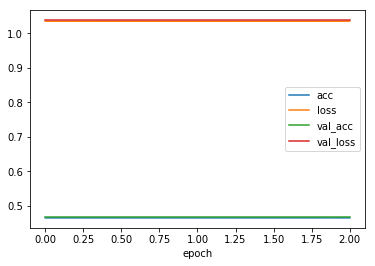

In [57]:
top_model_loss_history_df.plot(x=0)

In [26]:
# fine tune on full model
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

mobilenet_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# CREATE AN "REAL" MODEL FROM Mobilenet
# BY COPYING ALL THE LAYERS OF Mobilenet
model = Sequential()
for l in mobilenet_model.layers:
    model.add(l)


# CONCATENATE THE TWO MODELS
model.add(top_model)

# LOCK THE TOP CONV LAYERS
for layer in model.layers:
    layer.trainable = False

# COMPILE THE MODEL
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [32]:
model.load_weights(full_model_weight_path)

In [34]:
# load full mode result
npzfile = np.load(full_model_test_result)
y_true = npzfile['y_true']
y_pred = npzfile['y_pred']
log.debug(y_true.shape)
log.debug(y_pred.shape)

In [35]:
# report test accuracy
test_accuracy = 100*np.sum(np.argmax(y_pred, axis=1)==np.argmax(y_true, axis=1))/len(y_true)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 46.3922%


In [41]:
# report test accuracy on TTD
ttd_X1 = ttd_data_df.X.as_matrix()
ttd_y_pred = model.predict(paths_to_tensor(ttd_X1))
    
ttd_y_pred_two_classes=ttd_y_pred[:,[0,2]]
ttd_y_true = ttd_data_df.y.as_matrix()

In [42]:
ttd_test_accuracy = 100*np.sum(np.argmax(ttd_y_pred_two_classes, axis=1)==ttd_y_true)/len(ttd_y_true)
print('TTD Test accuracy: %.4f%%' % ttd_test_accuracy)

TTD Test accuracy: 73.2426%
